In [5]:
debug = True

In [6]:
from custum_frozen_lake_env import CustumFrozenLakeEnv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
env = CustumFrozenLakeEnv(map_name="8x8")

obs_space = env.observation_space
n_state = obs_space.n
print('Observation space')
print("Total {} states".format(n_state))

act_space = env.action_space
n_act = act_space.n
print('Action space')
print("Total {} actions".format(n_act))

Observation space
Total 64 states
Action space
Total 4 actions


###### plot_results
> - 정책은 화살표로, state의 어떤 값(value 혹은 visitation)은 색상으로 표현

In [8]:
def plot_results(policy, value, title="Value Function"):
    plt.figure(num=0)
    plt.imshow(np.reshape(value,(8,8)))
    plt.title(title)  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="r",alpha=policy[s][0],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="r",alpha=policy[s][1],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="r",alpha=policy[s][2],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="r",alpha=policy[s][3],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
    plt.show()

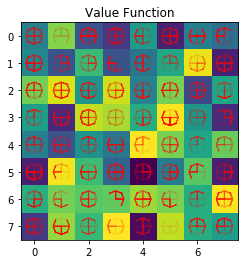

In [9]:
# test code

n_state = obs_space.n
n_act = act_space.n
random_policy = np.random.uniform(size=(n_state, n_act))
random_value = np.random.uniform(size=(n_state,))

plot_results(random_policy, random_value)

###### logsumexp

In [10]:
def logsumexp(x, scale = 1):
    x = np.array(x)/scale
    max_x = np.max(x,axis=1,keepdims=True)
    lse_x = max_x[:,0] + np.log(np.exp(x-max_x).sum()) # Numerical Stability
    lse_x = scale*lse_x
    return lse_x

In [11]:
# test code

n_state = obs_space.n
n_act = act_space.n

q = np.random.uniform(size=(n_state, n_act))

print(q[0, :])
print(np.max(q[0, :]) + np.log(np.exp(q - np.max(q, axis=1, keepdims=True)).sum()))
logsumexp(q)[0]

[0.44540104 0.22166276 0.27514282 0.12849194]
5.739598026888713


5.739598026888713

###### softmax

In [12]:
def softmax(x, scale = 1):
    x = np.array(x)/scale
    max_x = np.max(x,axis=1,keepdims=True)
    e_x = np.exp(x - max_x) # Numerical Stability
    p = e_x/np.sum(e_x,axis=1,keepdims=True)
    p = p/np.sum(p,axis=1,keepdims=True)
    return p

In [13]:
# test code

n_state = obs_space.n
n_act = act_space.n

q = np.random.uniform(size=(n_state, n_act))
policy = softmax(q)

print(q[0,:])
print(policy[0, :])

[0.92458902 0.65791069 0.85745507 0.37920573]
[0.30482146 0.23346867 0.28502938 0.17668049]


###### policy_evaluation
> In this step, value function for fixed policy $\pi$ is computed. 
We will mainly use Bellman expectation equation for $V_{\pi}$:
$$V_{\pi}(s)=\sum_{a}\pi(a|s)\sum_{s'}[r(s,a,s')+\gamma V_{\pi}(s')]P(s'|s,a)$$

> - week2에도 policy_evaluation 구현이 나오는데, 이때는 env.unwrapped.P를 이용했다. 그런데 이때 P는 사실 transition matrix가 아니라 (s, a)에 대한 transition prob, next state, reward를 남고 있는 dictionary이다.    
이와 다르게 아래 구현에서는 bellman operation연산을 vector화 하기 위해 P matrix와 R matrix를 생성하는 과정을 선행한다.

In [14]:
def policy_evaluation(env, policy, gamma=0.99, epsilon=1e-6, scale=1e-5):
    
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward
                
    # Random initial
    v = np.random.uniform(size=(n_state,))
    
    while True:
        v_prime = np.sum(policy*np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2),axis=1)
        dist = np.max(np.abs(v-v_prime))
        v = v_prime
        if dist < epsilon:
            break
    return v

###### soft_value_iteration
 > - 그냥 q-learning과 같고 policy를 구할때 q-value를 입력으로하는 softmax를 쓴것만 다르다.
- 그리고 q-function으로 value-function구할때 numerical stability를 위한 trick이 들어갔다.(logsumexp)

In [15]:
def soft_value_iteration(env,rewards=None,gamma=0.99,epsilon=1e-6,scale=1e-5):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
        
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                if rewards is None:
                    r[s][a][next_s]=reward
                else:
                    r[s][a][next_s]=rewards[s][a][next_s]
        
    value = np.random.uniform(size=(n_state,))
    
    if debug:
        print('Obs space:', obs_space, 'N_state:', n_state)
        print('Act_space:', act_space, 'N_act:', n_act)
        print("Transition prob P's shape:", P.shape)
        print("Reward func r's shape:", r.shape)
        print("Value function's shape:", value.shape)    
            
    while True:
        q = np.sum((r + gamma * np.tile(value[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2)
        v_prime = logsumexp(q, scale=scale)
        dist = np.max(np.abs(value-v_prime))
        value = v_prime
        if dist < epsilon:
            break
            
    policy = softmax(q, scale=scale)
    return policy, value

In [16]:
# test code
env = CustumFrozenLakeEnv(map_name="8x8")

obs_space = env.observation_space
n_state = obs_space.n
act_space = env.action_space
n_act = act_space.n

soft_value_iteration(env)


Obs space: Discrete(64) N_state: 64
Act_space: Discrete(4) N_act: 4
Transition prob P's shape: (64, 4, 64)
Reward func r's shape: (64, 4, 64)
Value function's shape: (64,)


(array([[0.00000000e+000, 5.00000000e-001, 5.00000000e-001,
         0.00000000e+000],
        [0.00000000e+000, 8.56595333e-193, 1.00000000e+000,
         3.72153407e-109],
        [0.00000000e+000, 1.18886553e-254, 1.00000000e+000,
         3.11641119e-137],
        [0.00000000e+000, 3.97982465e-296, 1.00000000e+000,
         1.85898593e-160],
        [0.00000000e+000, 2.47032823e-323, 1.00000000e+000,
         2.33152992e-189],
        [0.00000000e+000, 0.00000000e+000, 1.00000000e+000,
         9.75758336e-250],
        [0.00000000e+000, 3.99890737e-289, 1.00000000e+000,
         0.00000000e+000],
        [5.00000000e-001, 5.00000000e-001, 0.00000000e+000,
         0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         1.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         1.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         1.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 

###### get_visitation
> - getting state visitation for all states under given policy, $\rho_\pi(\mathbf{s})$
 - State action visitation
$$\begin{align}
\rho_{\pi}(s,a) &= \mathbb{E}[\sum_{t=0}^{\infty}\gamma^t\mathbb{1}(s_t=s,a_t=a)|\pi] \\
&= \sum_{t=0}^{\infty}\gamma^tP_{\pi}(s_t=s,a_t=a) \\
&= \sum_{t=0}^{\infty}\gamma^tP_{\pi}(a_t=a|s_t=s)P_{\pi}(s_t=s) \\
&= \pi(a|s)\sum_{t=0}^{\infty}\gamma^tP_{\pi}(s_t=s) \\
&= \pi(a|s)\rho_{\pi}(s) \\
\end{align}$$
 - State visitation
$$\begin{align}
\rho_{\pi}(s) &= \mathbb{E}[\sum_{t=0}^{\infty}\gamma^t\mathbb{1}(s_t=s)|\pi] \\
&= \sum_{t=0}^{\infty}\gamma^tP_{\pi}(s_t=s)  \\
&= P_{\pi}(s_0=s)+\gamma\sum_{t=1}^{\infty}\gamma^{t-1}\sum_{s',a'}P_{\pi}(s_t=s|s_{t-1} \\
&=s',a_{t-1}=a')P_{\pi}(s_{t-1}=s',a_{t-1}=a') \\
&= d(s)+\gamma\sum_{s',a'}P(s|s',a')\rho_{\pi}(s',a') \\
\end{align}$$
 - Bellman flow equation
$$\rho_{\pi}(s)= d(s) + \gamma\sum_{s',a'}P(s|s',a')\rho_{\pi}(s')\pi(a'|s')$$

In [17]:
def get_visitation(env, policy, gamma=0.99, epsilon=1e-6):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
    P = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
    
    d = np.zeros((n_state,))  # vector with n_state length
    d[0] = 1  # 
    
    rho_s = np.zeros((n_state,))
    rho_s[0] = 1
    while True:
        rho_sa = policy * np.tile(rho_s[:, np.newaxis], reps=(1, n_act))
        rho_s_prime = d + gamma * np.sum(np.sum(P * np.tile(rho_sa[:, :, np.newaxis], reps=(1, 1, n_state)), axis=0), axis=0)
        dist = np.max(np.abs(rho_s - rho_s_prime))
        rho_s = rho_s_prime
        if dist < epsilon:
            break
            
    rho_sa = policy * np.tile(rho_s[:, np.newaxis], reps=(1, n_act))
    
    return rho_s, rho_sa

In [18]:
# test code

gamma = 0.95
expert_policy, _ = soft_value_iteration(env, gamma=gamma)  # env knows expert's reward setting
_rho_s, _rho_sa = get_visitation(env, expert_policy, gamma=gamma)
print(_rho_s.shape, _rho_sa.shape)

Obs space: Discrete(64) N_state: 64
Act_space: Discrete(4) N_act: 4
Transition prob P's shape: (64, 4, 64)
Reward func r's shape: (64, 4, 64)
Value function's shape: (64,)
(64,) (64, 4)


###### Expert's policy
> - gym 환경에서 expert의 policy가 별도로 존재하지는 않기 때문에, gym의 reward setting이 optimal하다고 가정하고, soft MDP를 풀어(value iteration) 나온 policy를 expert의 policy로 사용한다.

Obs space: Discrete(64) N_state: 64
Act_space: Discrete(4) N_act: 4
Transition prob P's shape: (64, 4, 64)
Reward func r's shape: (64, 4, 64)
Value function's shape: (64,)

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


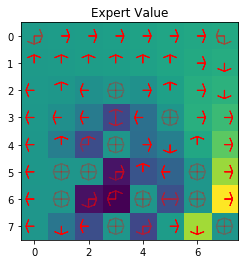

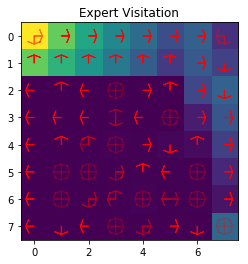

In [19]:
gamma = 0.95
expert_policy, _ = soft_value_iteration(env, gamma=gamma)  
# 2nd return value is expert's value function that is calculated with soft bellman equation.
# so it is differ from return value of policy_evaluation given expert's policy

expert_value = policy_evaluation(env, expert_policy, gamma=gamma)
expert_rho_s, expert_rho_sa = get_visitation(env, expert_policy, gamma=gamma)

env.reset()
env.render()

plot_results(expert_policy, expert_value, title='Expert Value')
plot_results(expert_policy, expert_rho_s, title='Expert Visitation')


###### Sample demonstrations from experts
> - expert's policy를 이용해 trajectory를 하나 뽑아본다.

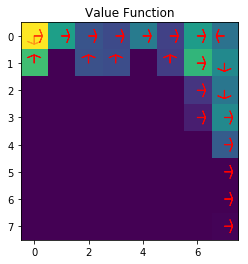

In [21]:
obs_space = env.observation_space
n_state = obs_space.n
act_space = env.action_space
n_act = act_space.n

n_episode = 1
rho_sa_hat = np.zeros((n_state, n_act))

for episode in range(n_episode):
    state = env.reset()
    t = 0
    done = False
    
    while not done:  # until episode ends
        t += 1
        action = np.random.choice(n_act, p=expert_policy[state])
        next_state, reward, done, info = env.step(action)
        rho_sa_hat[state][action] += gamma**t
        
        state = next_state
        
    rho_sa_hat[state][action] += gamma**t / (1-gamma)
    
rho_sa_hat = rho_sa_hat / n_episode  # expert's state-action visitation
rho_s_hat = np.sum(rho_sa_hat, axis=1)  # expert's state visitation

plot_results(rho_sa_hat / np.sum(rho_sa_hat+1e-10, axis=1, keepdims=True), rho_s_hat)

###### Maximum Entropy Inverse Reinforcement Learning

In [26]:
def maxentirl(env, rho_sa_hat, gamma=0.99, learning_rate=1e-3, n_iteration=10):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n

    P = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob

    r = np.zeros((n_state,n_act,n_state))
    
    # updating reward function and getting corresponding policy.
    for iteration in range(n_iteration):        
        # getting best policy given current (partially random) reward function.
        policy, _ = soft_value_iteration(env, rewards=r, gamma=gamma)
        
        # getting state-action visitation given policy.
        _, rho_sa = get_visitation(env, policy, gamma=gamma)
        
        grad = P * np.tile((rho_sa_hat - rho_sa)[:, :, np.newaxis], reps=(1, 1, n_state))
        
        r += learning_rate * grad
    
    policy, value = soft_value_iteration(env, rewards=r, gamma=gamma)
    
    return r, value, policy

In [27]:
irl_r, irl_value, trained_policy = maxentirl(env, rho_sa_hat, gamma=gamma)
trained_value = policy_evaluation(env, trained_policy, gamma=gamma)

Obs space: Discrete(64) N_state: 64
Act_space: Discrete(4) N_act: 4
Transition prob P's shape: (64, 4, 64)
Reward func r's shape: (64, 4, 64)
Value function's shape: (64,)
Obs space: Discrete(64) N_state: 64
Act_space: Discrete(4) N_act: 4
Transition prob P's shape: (64, 4, 64)
Reward func r's shape: (64, 4, 64)
Value function's shape: (64,)
Obs space: Discrete(64) N_state: 64
Act_space: Discrete(4) N_act: 4
Transition prob P's shape: (64, 4, 64)
Reward func r's shape: (64, 4, 64)
Value function's shape: (64,)
Obs space: Discrete(64) N_state: 64
Act_space: Discrete(4) N_act: 4
Transition prob P's shape: (64, 4, 64)
Reward func r's shape: (64, 4, 64)
Value function's shape: (64,)
Obs space: Discrete(64) N_state: 64
Act_space: Discrete(4) N_act: 4
Transition prob P's shape: (64, 4, 64)
Reward func r's shape: (64, 4, 64)
Value function's shape: (64,)
Obs space: Discrete(64) N_state: 64
Act_space: Discrete(4) N_act: 4
Transition prob P's shape: (64, 4, 64)
Reward func r's shape: (64, 4, 64